In [1]:
from scope_utils import set_scope, get_waveform, get_trace_data, TraceData
from Peak_Search import ini_peak_search, reso_det, mod_peak_search,zero_measure,fir_measure
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence
from utils_dBm import dBm_to_Vpp, Vpp_to_dBm, Vpp_to_Vrms, Vrms_to_watt
import csv

In [2]:
resource_name_oscilloscope = "USB0::0x1AB1::0x04CE::DS1ZA242902611::INSTR"
rm = pyvisa.ResourceManager()
scope: pyvisa.resources.USBInstrument = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZA242902611::INSTR", read_termination = "\n")

In [3]:
def get_rev_trace(
    scope: pyvisa.resources.USBInstrument, channels: Sequence[int]
)-> TraceData:
    scope.write(":SINGLE")
    while True:
        if scope.query(":TRIG:STAT?") == "STOP":
            break
        time.sleep(0.05)
    trace = get_trace_data(scope, channels)
    scope.write(":CLEAR")
    ref = trace.transmission
    rev= -1.*ref+np.mean(ref) 
    return rev

In [4]:
def save_data(
        main_data,
        fre,
        Vset,
        fname,
        run_name,
        overwrite = True
):
        with h5py.File(fname, "a") as f:
                if run_name in f.keys():
                        if overwrite:
                                del f[run_name]
                try:
                        dset = f.create_dataset(run_name, data=main_data)
                except TypeError:
                        print("Error saving data!")
                        return main_data
                dset.attrs['frequency'] = fre
                dset.attrs['set_voltage'] = Vset

In [5]:
channel1 = 1
channel2 = 2
scope.write(":RUN")
time.sleep(1)
#scope.write(":SINGLE")
scope.write(":ACQuire:MDEPth 30000")

23

In [10]:
scope.write(":SINGLE")
time.sleep(1)
read_V = get_rev_trace(scope, [channel1])
time.sleep(1)
pickup_V = get_rev_trace(scope, [channel2])
data = [read_V,pickup_V]

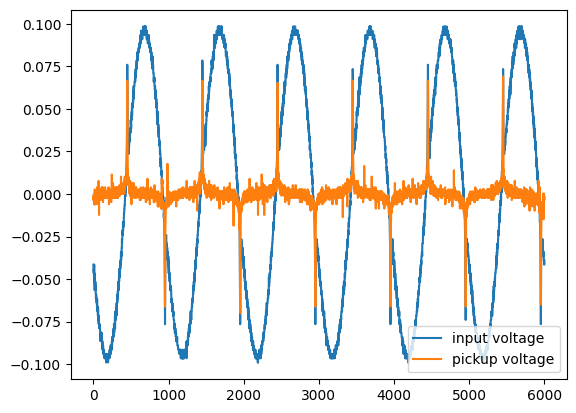

In [11]:
plt.plot(read_V, label = "input voltage")
plt.plot(pickup_V, label = "pickup voltage")
plt.legend()

In [14]:
file_name = "hystersis_2_28_2024.hdf"
rname = "10-5"
frequency = 10
set_voltage = 10
save_data(data, fre = frequency , Vset = set_voltage, fname = file_name , run_name = rname, overwrite = True)